In [1]:
# ----------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup
# ----------------------------------------------------------

import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Optional display settings
import warnings
warnings.filterwarnings("ignore")

# Add custom script directory if needed
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# Define base data directories
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"
proc_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy"
modality_dir = os.path.join(data_dir, "modality_modelling")

# File paths
gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA_complete.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")

# Combined facility file including proposed uplift sites
facilities_path = os.path.join(proc_dir, "facilities_with_proposed_sites.gpkg")


In [2]:
# ------------------------------------------------------------------
# Step 2 – Filter Travel Matrix for Reachable Facility Sites (Car ≤ 90 mins)
# ------------------------------------------------------------------

# 2.1 – Reload full travel matrix
travel_df = pd.read_csv(travel_csv_path)

# 2.2 – Load facility sites (including proposed) and extract valid LSOAs
facilities_gdf = gpd.read_file(facilities_path)
valid_lsoas = facilities_gdf["lsoa21cd"].astype(str).unique()

# 2.3 – Filter travel matrix where destination is a valid facility LSOA
travel_df["destination_name"] = travel_df["destination_name"].astype(str)
travel_df_filtered = travel_df[
    travel_df["destination_name"].isin(valid_lsoas)
].copy()

# 2.4 – Further filter to only trips ≤ 90 minutes by car
travel_df_filtered = travel_df_filtered[
    travel_df_filtered["travel_time_car"] <= 90
].copy()

# 2.5 – Confirm shape and max value
print("Filtered travel matrix shape:", travel_df_filtered.shape)
print("Max car travel time (should be ≤ 90):", travel_df_filtered["travel_time_car"].max())


Filtered travel matrix shape: (38160, 5)
Max car travel time (should be ≤ 90): 89.9979684515


In [3]:
# ----------------------------------------------------------
# Step 3 – Load LSOA Population Data (Age 50–74) from GPKG
# ----------------------------------------------------------

lsoa_gdf = gpd.read_file(gpkg_path)

# Define and validate expected columns
age_cols_50_74 = ["age_50_54", "age_55_59", "age_60_64", "age_65_69", "age_70_74"]
missing_cols = [col for col in age_cols_50_74 if col not in lsoa_gdf.columns]
if missing_cols:
    raise ValueError(f"Missing expected age columns: {missing_cols}")

# Compute population aged 50–74
lsoa_gdf["pop_50_74"] = lsoa_gdf[age_cols_50_74].sum(axis=1)

# Retain essential columns only
lsoa_pop = lsoa_gdf[["lsoa21cd", "pop_50_74", "geometry"]].copy()
lsoa_pop["lsoa21cd"] = lsoa_pop["lsoa21cd"].astype(str)

print(f"LSOA population GeoDataFrame loaded: {lsoa_pop.shape[0]} rows")
display(lsoa_pop.head())


LSOA population GeoDataFrame loaded: 3451 rows


,lsoa21cd,pop_50_74,geometry
0,E01020484,568.83,"MULTIPOLYGON (((401918.077 78945.278, 401919.4..."
1,E01020481,643.13,"MULTIPOLYGON (((403211.07 78762.983, 403211.07..."
2,E01020482,608.53,"MULTIPOLYGON (((403126.904 78828.641, 403127.4..."
3,E01020479,419.26,"MULTIPOLYGON (((403027.597 79673.678, 403027.8..."
4,E01020478,464.03,"MULTIPOLYGON (((402493.1 79584.202, 402511.903..."


In [4]:
# ----------------------------------------------------------
# Step 4 – Filter to < 60 min by Car and Merge LSOA 50–74 Population
# ----------------------------------------------------------

# 4.1 – Further filter travel matrix to < 60 mins
travel_df_60 = travel_df_filtered[
    travel_df_filtered["travel_time_car"] < 60
].copy()

# 4.2 – Merge population onto origin LSOA (i.e., where people live)
travel_df_60 = travel_df_60.merge(
    lsoa_pop[["lsoa21cd", "pop_50_74"]],
    how="left",
    left_on="origin_name",
    right_on="lsoa21cd"
)

# 4.3 – Safety check: fill any missing population values with 0
missing_pop = travel_df_60["pop_50_74"].isna().sum()
if missing_pop > 0:
    print(f"Warning: {missing_pop} origin LSOAs missing population – filling with 0")
    travel_df_60["pop_50_74"] = travel_df_60["pop_50_74"].fillna(0)

# 4.4 – Drop redundant join key
travel_df_60 = travel_df_60.drop(columns=["lsoa21cd"])

# 4.5 – Confirm merge
print(f"Merged population into <60 min travel matrix. Shape: {travel_df_60.shape}")
display(travel_df_60.head())


Merged population into <60 min travel matrix. Shape: (20305, 6)


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,pop_50_74
0,E01014901,E01014830,42.202264,92.512264,92.512264,523.04
1,E01014988,E01014830,45.774564,119.344564,116.344564,509.82
2,E01018785,E01015092,29.387906,64.517906,64.517906,838.50
3,E01032060,E01014444,20.838899,65.488899,65.488899,626.83
4,E01032069,E01014444,42.010978,93.380978,93.380978,490.48


In [7]:
# ----------------------------------------------------------
# Step 5 – Merge Endoscopy Room Counts by Destination LSOA (< 60 min)
# ----------------------------------------------------------

# 5.1 – Create lookup of endoscopy rooms per destination LSOA
room_lookup = (
    facilities_gdf[["lsoa21cd", "Endoscopy Rooms"]]
    .dropna(subset=["lsoa21cd", "Endoscopy Rooms"])
    .groupby("lsoa21cd", as_index=False)
    .sum()
    .rename(columns={
        "lsoa21cd": "destination_name",
        "Endoscopy Rooms": "rooms_at_destination"
    })
)

# 5.2 – Merge into <60 min travel matrix (on destination LSOA)
travel_df_60 = travel_df_60.merge(
    room_lookup,
    on="destination_name",
    how="left"
)

# 5.3 – Handle any unmatched destinations
missing_rooms = travel_df_60["rooms_at_destination"].isna().sum()
if missing_rooms > 0:
    print(f"Warning: {missing_rooms} destination LSOAs missing room data – filling with 0")
    travel_df_60["rooms_at_destination"] = travel_df_60["rooms_at_destination"].fillna(0)

# 5.4 – Final structure check
print("Travel matrix now includes population (origin) and endoscopy rooms (destination):")
display(travel_df_60.head())


Travel matrix now includes population (origin) and endoscopy rooms (destination):


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,pop_50_74,rooms_at_destination_x,rooms_at_destination_y,rooms_at_destination
0,E01014901,E01014830,42.202264,92.512264,92.512264,523.04,1,1,1
1,E01014988,E01014830,45.774564,119.344564,116.344564,509.82,1,1,1
2,E01018785,E01015092,29.387906,64.517906,64.517906,838.50,5,5,5
3,E01032060,E01014444,20.838899,65.488899,65.488899,626.83,3,3,3
4,E01032069,E01014444,42.010978,93.380978,93.380978,490.48,3,3,3


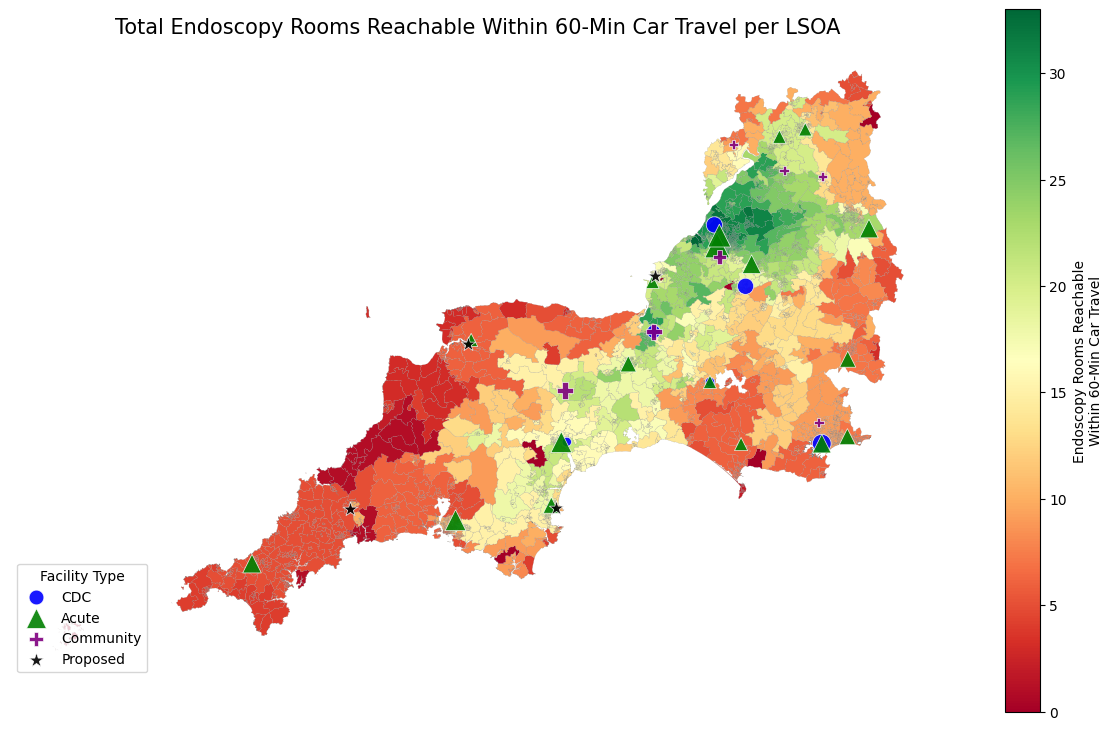

In [13]:
# ----------------------------------------------------------
# Step 5a – Plot Reachable Endoscopy Rooms (with Proposed Site Centroids, <60 min, Green = More)
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# Step 1 – Aggregate reachable rooms within 60 min
rooms_within_60 = (
    travel_df_60
    .groupby("origin_name", as_index=False)["rooms_at_destination"]
    .sum()
    .rename(columns={
        "origin_name": "lsoa21cd",
        "rooms_at_destination": "reachable_rooms_60min"
    })
)

# Step 2 – Join with LSOA geometry
lsoa_geom_merged = lsoa_gdf[["lsoa21cd", "geometry"]].merge(rooms_within_60, on="lsoa21cd", how="left")
lsoa_geom_merged["reachable_rooms_60min"] = lsoa_geom_merged["reachable_rooms_60min"].fillna(0)

# Step 3 – Convert facility polygons to centroids
facilities_plot_gdf = facilities_gdf.copy()
facilities_plot_gdf["geometry"] = facilities_plot_gdf["geometry"].centroid  # safe for visualisation

# Step 4 – Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot LSOAs coloured by reachable room count (green = more, red = less)
lsoa_geom_merged.plot(
    column="reachable_rooms_60min",
    cmap="RdYlGn",  # green for more, red for less
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Endoscopy Rooms Reachable\nWithin 60-Min Car Travel", "shrink": 0.6},
    ax=ax
)

# Plot facility markers with different marker sizes for Proposed sites
for label, colour, marker in [
    ("CDC", "blue", "o"),
    ("Acute", "green", "^"),
    ("Community", "purple", "P"),
    ("Proposed", "black", "*")
]:
    subset = facilities_plot_gdf[facilities_plot_gdf["source"] == label]
    if not subset.empty:
        size = 120 if label == "Proposed" else subset["Endoscopy Rooms"] * 45
        subset.plot(
            ax=ax,
            color=colour,
            markersize=size,
            marker=marker,
            label=label,
            alpha=0.9,
            edgecolor="white",
            linewidth=0.5
        )


# Step 5 – Final formatting
ax.set_title("Total Endoscopy Rooms Reachable Within 60-Min Car Travel per LSOA", fontsize=15)
ax.axis("off")
ax.legend(title="Facility Type", loc="lower left", frameon=True)

plt.tight_layout()
plt.show()


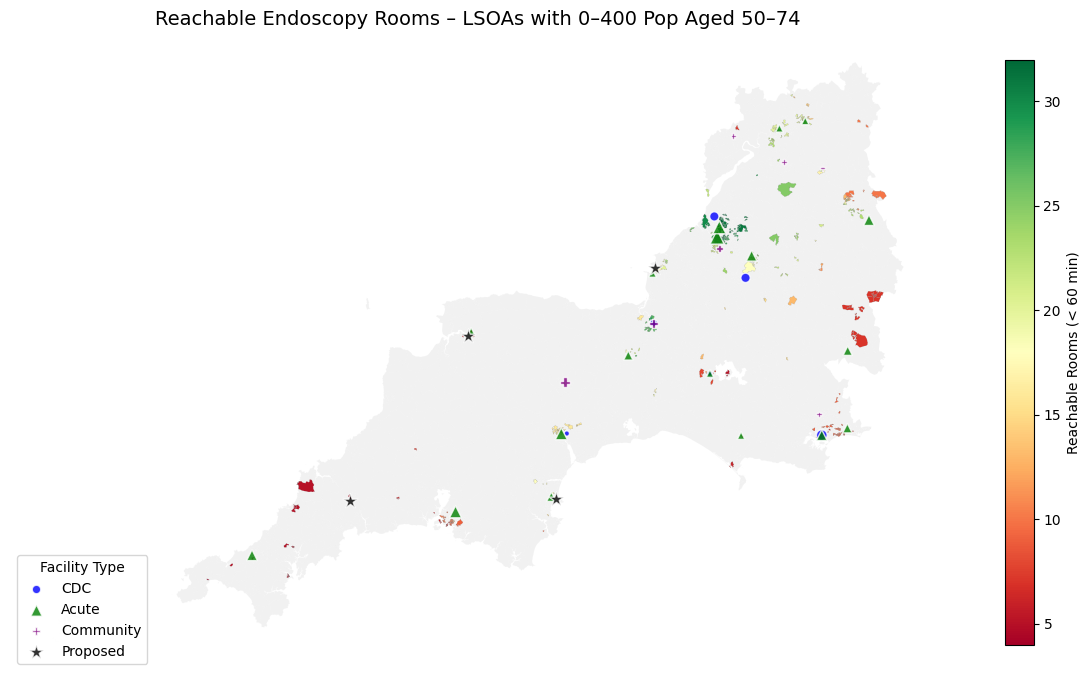

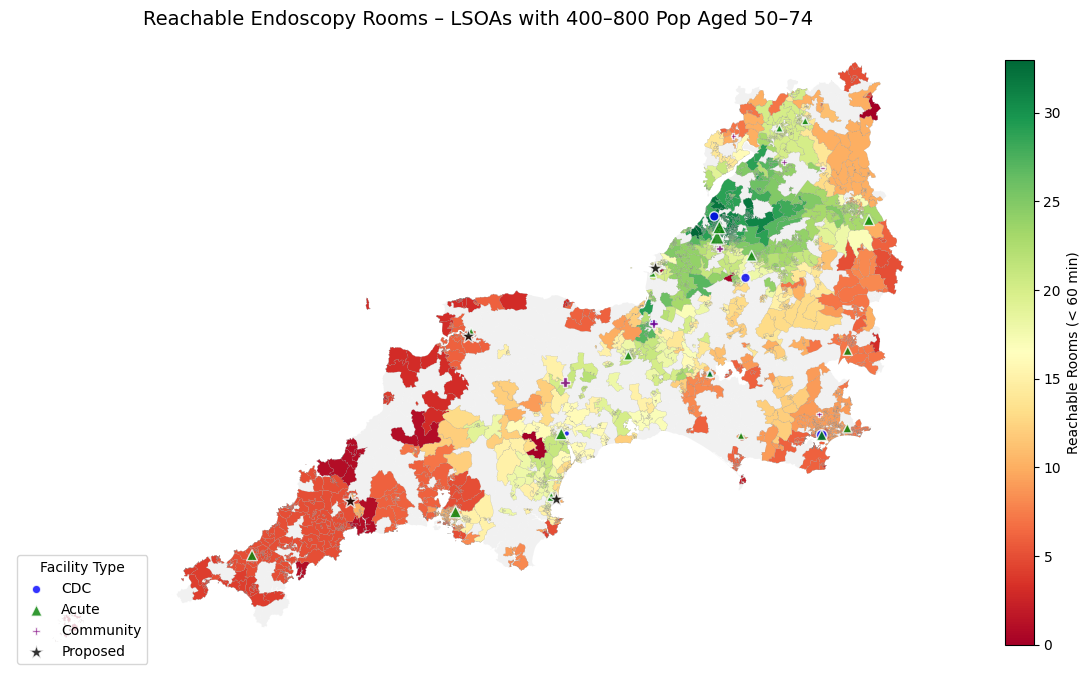

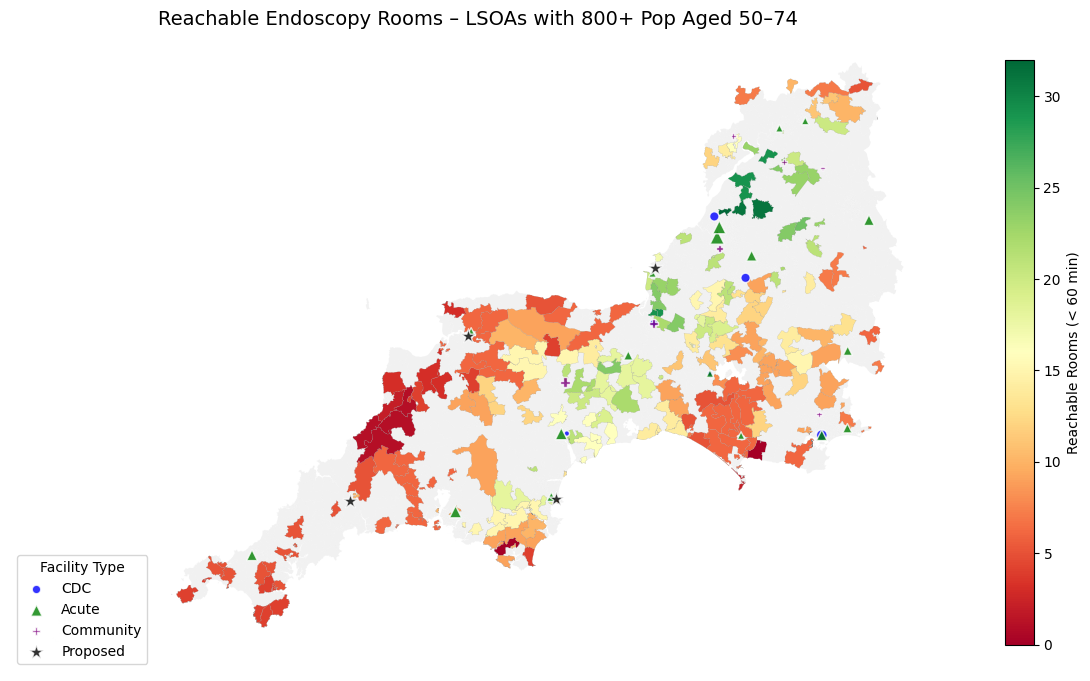

In [16]:
# ----------------------------------------------------------
# Step 5b – Show Reachable Rooms by LSOA Population Band (0–400, 400–800, 800+) with <60 min filter
# ----------------------------------------------------------

# Step 1 – Merge population and reachable room data into base geometry
lsoa_plot_gdf = (
    lsoa_gdf[["lsoa21cd", "geometry", "pop_50_74"]]
    .merge(lsoa_geom_merged[["lsoa21cd", "reachable_rooms_60min"]], on="lsoa21cd", how="left")
)

lsoa_plot_gdf["reachable_rooms_60min"] = lsoa_plot_gdf["reachable_rooms_60min"].fillna(0)
lsoa_plot_gdf["pop_50_74"] = lsoa_plot_gdf["pop_50_74"].fillna(0)

# Step 2 – Define population bands
population_bands = [
    ("0–400", 0, 400),
    ("400–800", 400, 800),
    ("800+", 800, float("inf"))
]

# Step 3 – Convert facility geometries to centroids for uniform plotting
facilities_plot_gdf = facilities_gdf.copy()
facilities_plot_gdf["geometry"] = facilities_plot_gdf["geometry"].centroid

# Step 4 – Define plotting function
def plot_band(title_suffix, pop_min, pop_max):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Highlight and non-highlight LSOAs
    highlight = lsoa_plot_gdf[(lsoa_plot_gdf["pop_50_74"] > pop_min) & (lsoa_plot_gdf["pop_50_74"] <= pop_max)]
    other = lsoa_plot_gdf.drop(index=highlight.index)
    
    # Plot greyed-out non-target LSOAs
    other.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1, alpha=0.3)
    
    # Plot highlighted band with reachable rooms, reversed cmap (green=more)
    highlight.plot(
        ax=ax,
        column="reachable_rooms_60min",
        cmap="RdYlGn",
        linewidth=0.1,
        edgecolor="grey",
        legend=True,
        legend_kwds={"label": "Reachable Rooms (< 60 min)", "shrink": 0.5}
    )
    
    # Overlay facility points with adjusted marker sizes
    for label, colour, marker in [
        ("CDC", "blue", "o"),
        ("Acute", "green", "^"),
        ("Community", "purple", "P"),
        ("Proposed", "black", "*")
    ]:
        subset = facilities_plot_gdf[facilities_plot_gdf["source"] == label]
        if not subset.empty:
            size = 120 if label == "Proposed" else subset["Endoscopy Rooms"] * 15
            subset.plot(
                ax=ax,
                color=colour,
                markersize=size,
                marker=marker,
                label=label,
                alpha=0.8,
                edgecolor="white"
            )

    # Final formatting
    ax.set_title(f"Reachable Endoscopy Rooms – LSOAs with {title_suffix} Pop Aged 50–74", fontsize=14)
    ax.axis("off")
    ax.legend(title="Facility Type", loc="lower left", frameon=True)
    plt.tight_layout()
    plt.show()

# Step 5 – Generate plots for all population bands
for label, pop_min, pop_max in population_bands:
    plot_band(label, pop_min, pop_max)


In [17]:
# ----------------------------------------------------------
# Step 6 – Competition-Adjusted Rooms per 100k (Catchment Pressure Logic, < 60 min)
# ----------------------------------------------------------

# 6.1 – Total population competing for each facility destination (≤ 60 min travel)
facility_pop = (
    travel_df_60
    .groupby("destination_name", as_index=False)["pop_50_74"]
    .sum()
    .rename(columns={"pop_50_74": "competing_pop_50_74"})
)

# 6.2 – Merge competing population back into travel matrix
travel_df_60 = travel_df_60.merge(facility_pop, on="destination_name", how="left")

# 6.3 – Calculate contribution from each destination (adjusted for competition)
travel_df_60["room_contrib_per_100k"] = (
    travel_df_60["rooms_at_destination"] /
    travel_df_60["competing_pop_50_74"].replace(0, np.nan)
) * 100_000

# 6.4 – Aggregate all contributions to each origin LSOA
competition_access = (
    travel_df_60
    .groupby("origin_name", as_index=False)["room_contrib_per_100k"]
    .sum()
    .rename(columns={
        "origin_name": "lsoa21cd",
        "room_contrib_per_100k": "rooms_per_100k_competition"
    })
)

# 6.5 – Access tier classification logic
def classify_access(x):
    if x < 3.5:
        return "Low"
    elif x < 4.0:
        return "Marginal"
    else:
        return "Adequate"

competition_access["access_flag"] = competition_access["rooms_per_100k_competition"].apply(classify_access)

# 6.6 – Confirm results
print(f"Completed competition-adjusted scoring for {competition_access.shape[0]} LSOAs")
display(competition_access.head())
display(competition_access["access_flag"].value_counts())


Completed competition-adjusted scoring for 3444 LSOAs


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01014014,1.730148,Low
1,E01014031,2.690179,Low
2,E01014032,1.518772,Low
3,E01014036,2.155768,Low
4,E01014057,1.730148,Low


access_flag
Adequate    1480
Low         1450
Marginal     514
Name: count, dtype: int64

In [18]:
# ----------------------------------------------------------
# Step 7a – Merge Competition-Based Access Scores into LSOA Geometry
# ----------------------------------------------------------

# Merge competition-adjusted access scores into base LSOA GeoDataFrame
lsoa_access_gdf = lsoa_gdf.merge(
    competition_access,
    on="lsoa21cd",
    how="left"
)

# Fill missing values for access scores and flags
lsoa_access_gdf["rooms_per_100k_competition"] = lsoa_access_gdf["rooms_per_100k_competition"].fillna(0)
lsoa_access_gdf["access_flag"] = lsoa_access_gdf["access_flag"].fillna("Unknown")

# Confirm structure and preview results
print(f"GeoDataFrame merged: {lsoa_access_gdf.shape[0]} LSOAs")
display(lsoa_access_gdf[["lsoa21cd", "rooms_per_100k_competition", "access_flag"]].head())


GeoDataFrame merged: 3451 LSOAs


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01020484,2.295663,Low
1,E01020481,0.999220,Low
2,E01020482,2.295663,Low
3,E01020479,2.295663,Low
4,E01020478,2.295663,Low


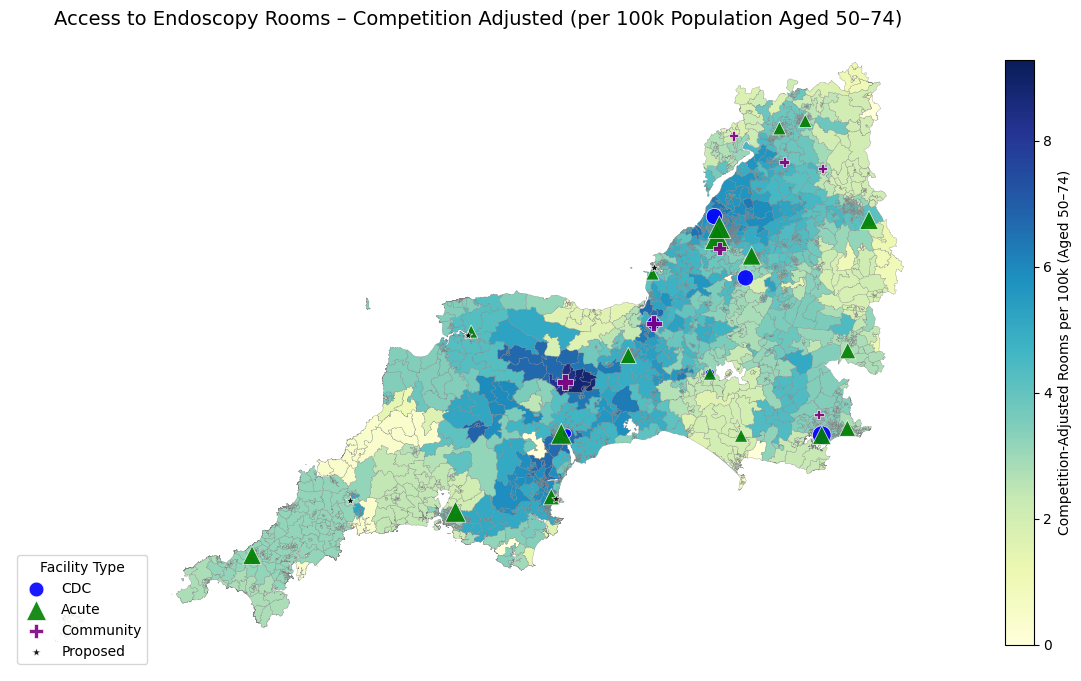

In [19]:
# ----------------------------------------------------------
# Step 7b – Choropleth: Rooms per 100k (Competition Adjusted)
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# Step 1 – Convert all facility geometries to centroids for safe marker plotting
facilities_plot_gdf = facilities_gdf.copy()
facilities_plot_gdf["geometry"] = facilities_plot_gdf["geometry"].centroid

# Step 2 – Set up figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Step 3 – Plot LSOAs by competition-adjusted score
lsoa_access_gdf.plot(
    column="rooms_per_100k_competition",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={
        "label": "Competition-Adjusted Rooms per 100k (Aged 50–74)",
        "shrink": 0.5
    },
    ax=ax
)

# Step 4 – Overlay facility markers (including proposed sites)
for label, colour, marker in [
    ("CDC", "blue", "o"),
    ("Acute", "green", "^"),
    ("Community", "purple", "P"),
    ("Proposed", "black", "*")
]:
    subset = facilities_plot_gdf[facilities_plot_gdf["source"] == label]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=colour,
            markersize=subset["Endoscopy Rooms"] * 45,
            marker=marker,
            label=label,
            alpha=0.9,
            edgecolor="white",
            linewidth=0.5
        )

# Step 5 – Final formatting
ax.set_title("Access to Endoscopy Rooms – Competition Adjusted (per 100k Population Aged 50–74)", fontsize=14)
ax.axis("off")
ax.legend(title="Facility Type", loc="lower left", frameon=True)
plt.tight_layout()
plt.show()


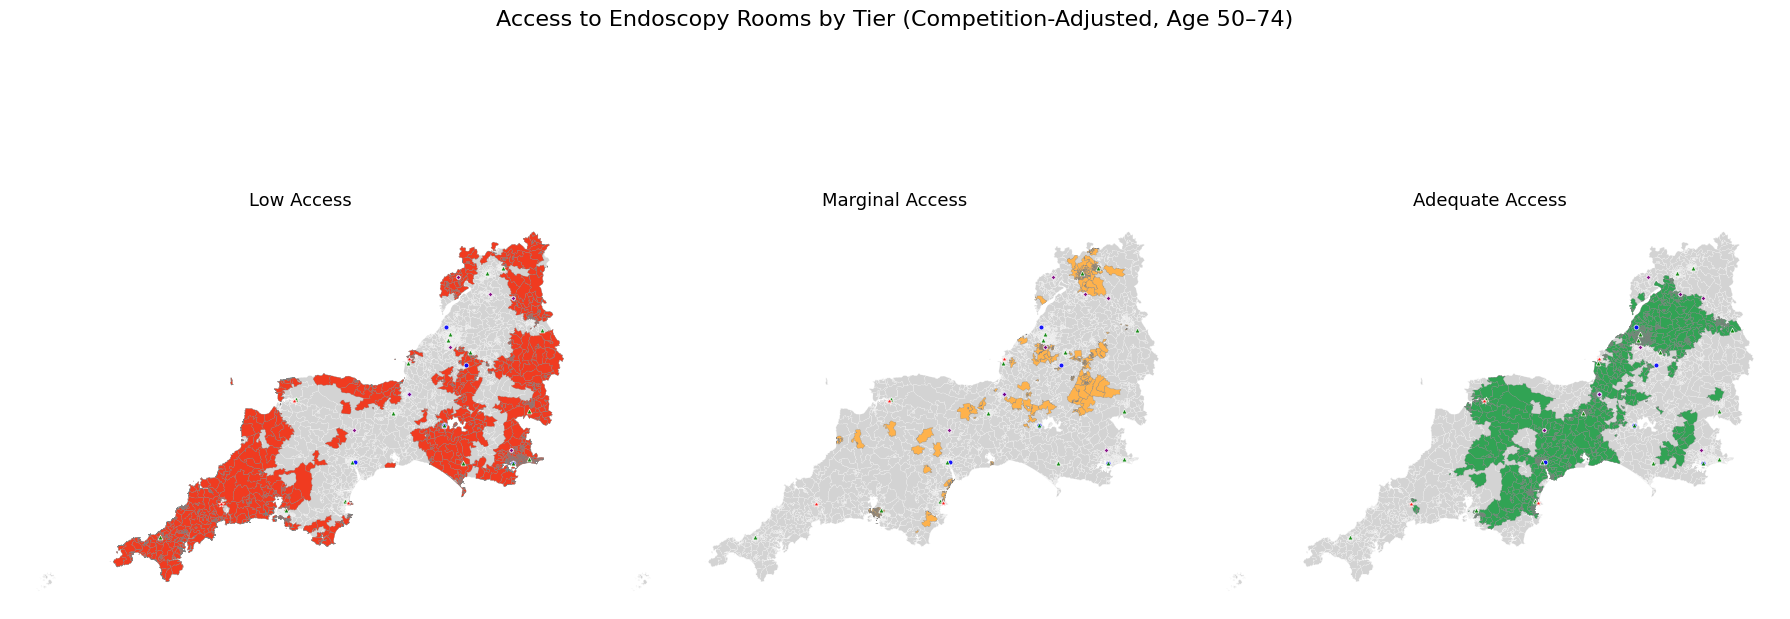

In [20]:
# ----------------------------------------------------------
# Step 7c – Subplots: Low / Marginal / Adequate Access Tiers
# ----------------------------------------------------------

# Step 1 – Convert facility geometries to centroids for plotting
facilities_plot_gdf = facilities_gdf.copy()
facilities_plot_gdf["geometry"] = facilities_plot_gdf["geometry"].centroid

# Step 2 – Define tier order and colours
tier_order = ["Low", "Marginal", "Adequate"]
colours = ["#f03b20", "#feb24c", "#31a354"]  # Red, Orange, Green

# Step 3 – Create subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for i, tier in enumerate(tier_order):
    ax = axes[i]
    
    # Grey background for all LSOAs
    lsoa_access_gdf.plot(
        color="lightgrey",
        edgecolor="white",
        linewidth=0.1,
        ax=ax
    )
    
    # Highlight LSOAs in current access tier
    lsoa_access_gdf[lsoa_access_gdf["access_flag"] == tier].plot(
        color=colours[i],
        edgecolor="grey",
        linewidth=0.2,
        ax=ax
    )
    
    # Overlay facilities by type
    for label, colour, marker in [
        ("CDC", "blue", "o"),
        ("Acute", "green", "^"),
        ("Community", "purple", "P"),
        ("Proposed", "black", "*")
    ]:
        subset = facilities_plot_gdf[facilities_plot_gdf["source"] == label]
        if not subset.empty:
            size = 20 if label == "Proposed" else 12
            subset.plot(
                ax=ax,
                color=colour,
                markersize=size,
                marker=marker,
                alpha=0.9,
                edgecolor="white",
                linewidth=0.5
            )
    
    ax.set_title(f"{tier} Access", fontsize=13)
    ax.axis("off")

# Step 4 – Final formatting
plt.suptitle("Access to Endoscopy Rooms by Tier (Competition-Adjusted, Age 50–74)", fontsize=16)
plt.tight_layout()
plt.show()


In [21]:
# ----------------------------------------------------------
# Step 8 – Prepare LSOA Competition Access Scores for Encoding (No Export Yet)
# ----------------------------------------------------------

# Preview final GeoDataFrame details
print(f"Final GeoDataFrame ready: {lsoa_access_gdf.shape[0]} LSOAs")
print("Columns available:", lsoa_access_gdf.columns.tolist())

# Define target export path (for future use)
export_path = os.path.join(
    proc_dir,
    "lsoa_competition_access.gpkg"
)

# Encoding ready — actual export skipped here
# To export later, uncomment and run:
# lsoa_access_gdf.to_file(export_path, layer="access_scores", driver="GPKG")

# Summary messages
print("Access scores and geometry are prepared and ready for export.")
print(f"Export path set to: {export_path}")
print("Export is currently skipped — run export command when ready.")


Final GeoDataFrame ready: 3451 LSOAs
Columns available: ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'geometry', 'pop_50_74', 'rooms_per_100k_competition', 'access_flag']
Access scores and geometry are prepared and ready for export.
Export path set to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/lsoa_competition_access.gpkg
Export is currently skipped — run export command when ready.


In [24]:
# ----------------------------------------------------------
# Step 9 – Filter and Prepare Underserved LSOAs (Low, Marginal, or No Access)
# ----------------------------------------------------------

# Step 1 – Filter underserved LSOAs including 'No Access'
underserved_gdf = lsoa_access_gdf[
    lsoa_access_gdf["access_flag"].isin(["Low", "Marginal", "No Access"])
].copy()

# Step 2 – Ensure geometry column is set correctly
underserved_gdf = underserved_gdf.set_geometry("geometry")

# Step 3 – Reproject to British National Grid (EPSG:27700) for clustering or spatial operations
underserved_gdf = underserved_gdf.to_crs(epsg=27700)

# Step 4 – Preview filtered underserved LSOAs with diagnostics
print("Step 9 complete: filtered underserved LSOAs with access flags")
display(underserved_gdf.head())
display(underserved_gdf["access_flag"].value_counts())


Step 9 complete: filtered underserved LSOAs with access flags


,ICB23NM,ladnm,ladcd,msoa21nm,msoa21cd,lsoa21nmw,lsoa21cd,total_population,age_0_4,age_5_9,...,age_85_plus,lat,long,bng_e,bng_n,lsoa21nm,geometry,pop_50_74,rooms_per_100k_competition,access_flag
0,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020484,1444.99,43.76,70.21,...,51.90,50.60036,-1.96951,402254,77850,Dorset 042G,"MULTIPOLYGON (((401918.077 78945.278, 401919.4...",568.83,2.295663,Low
1,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020481,1347.30,39.69,32.56,...,83.44,50.60304,-1.95604,403207,78149,Dorset 042D,"MULTIPOLYGON (((403211.07 78762.983, 403211.07...",643.13,0.999220,Low
2,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020482,1585.42,70.21,77.34,...,52.92,50.60719,-1.96286,402724,78610,Dorset 042E,"MULTIPOLYGON (((403126.904 78828.641, 403127.4...",608.53,2.295663,Low
3,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020479,1150.91,33.58,32.56,...,155.69,50.61312,-1.96203,402782,79270,Dorset 042B,"MULTIPOLYGON (((403027.597 79673.678, 403027.8...",419.26,2.295663,Low
4,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020478,1129.54,37.65,44.77,...,55.97,50.61287,-1.97186,402087,79241,Dorset 042A,"MULTIPOLYGON (((402493.1 79584.202, 402511.903...",464.03,2.295663,Low


access_flag
Low         1450
Marginal     514
Name: count, dtype: int64

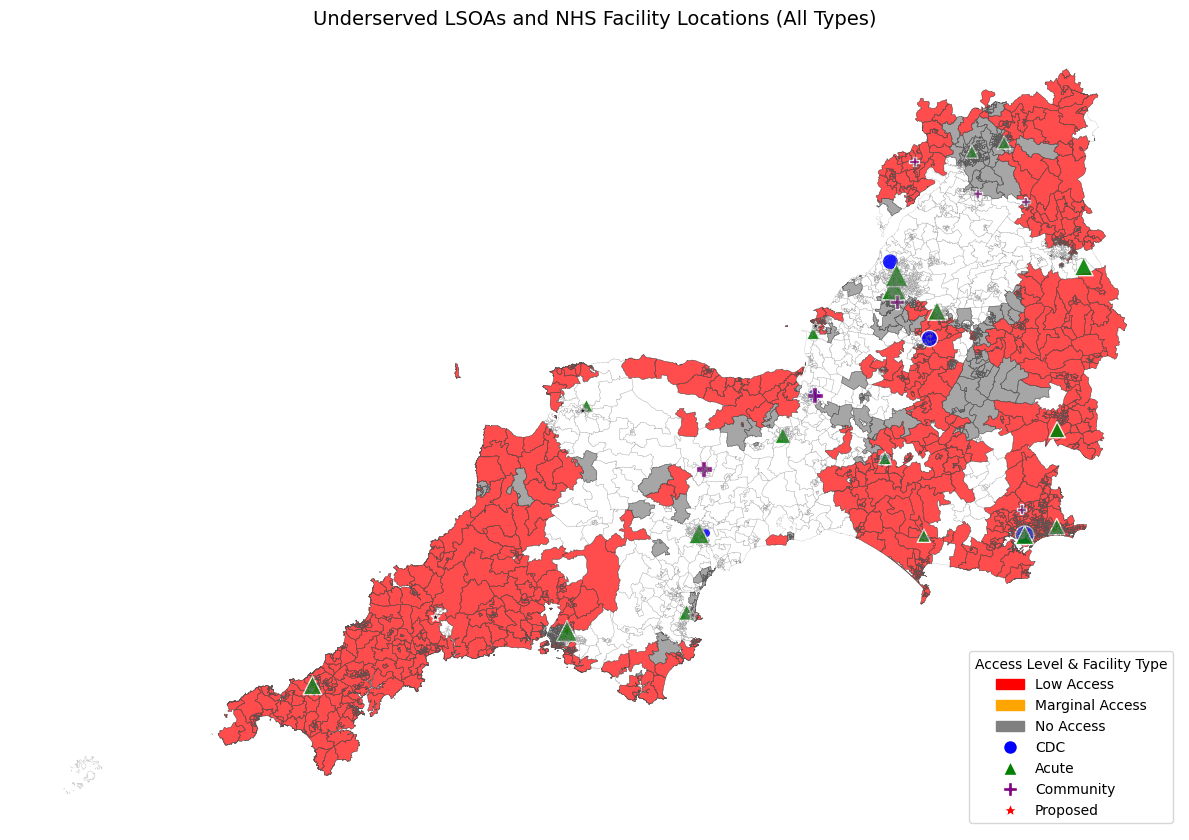

In [27]:
# ----------------------------------------------------------
# Step 10 – Visual Preview: Underserved LSOAs + NHS Facilities (All Sources)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Step 1 – Reproject data to British National Grid (EPSG:27700)
facilities_plot_gdf = facilities_gdf.copy()
facilities_plot_gdf["geometry"] = facilities_plot_gdf["geometry"].centroid  # for plotting
facilities_plot_gdf = facilities_plot_gdf.to_crs(epsg=27700)

lsoa_borders = lsoa_gdf.to_crs(epsg=27700).boundary
underserved_gdf = underserved_gdf.to_crs(epsg=27700)

# Step 2 – Define colour map including 'No Access'
access_colors = {"Low": 0, "Marginal": 1, "No Access": 2}
cmap = ListedColormap(["red", "orange", "grey"])
underserved_gdf["access_code"] = underserved_gdf["access_flag"].map(access_colors)

# Step 3 – Set up plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot underserved LSOAs by access_code
underserved_gdf.plot(
    ax=ax,
    column="access_code",
    cmap=cmap,
    linewidth=0.3,
    edgecolor="black",
    alpha=0.7,
    legend=False
)

# Overlay LSOA boundaries
lsoa_borders.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.4
)

# Step 4 – Plot all facilities by type (with Proposed included)
for label, colour, marker in [
    ("CDC", "blue", "o"),
    ("Acute", "green", "^"),
    ("Community", "purple", "P"),
    ("Proposed", "black", "*")
]:
    subset = facilities_plot_gdf[facilities_plot_gdf["source"] == label]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=colour,
            markersize=subset["Endoscopy Rooms"] * 45,
            marker=marker,
            label=label,
            alpha=0.9,
            edgecolor="white"
        )

# Step 5 – Custom legend with No Access added
access_patches = [
    mpatches.Patch(color='red', label='Low Access'),
    mpatches.Patch(color='orange', label='Marginal Access'),
    mpatches.Patch(color='grey', label='No Access')
]
facility_markers = [
    plt.Line2D([0], [0], marker=mk, color='w', markerfacecolor=col, markersize=10, label=lbl)
    for lbl, col, mk in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P"), ("Proposed", "red", "*")]
]
ax.legend(
    handles=access_patches + facility_markers,
    title="Access Level & Facility Type",
    loc="lower right",
    frameon=True
)

# Step 6 – Final formatting
ax.set_title("Underserved LSOAs and NHS Facility Locations (All Types)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()
